# Принятие решений в бизнесе на основе данных

# Описание проекта

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

# Цель проекта

Определить главные гипотезы для увеличения выручки и подвести итоги проведенного А/В - теста.

# Описание данных

Данные для первой части:

1. Файл /datasets/hypothesis.csv. 
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части:

2. Файл /datasets/orders.csv. Скачать датасет
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

3. Файл /datasets/visitors.csv. Скачать датасет
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста


## Загружаем данные и готовим их к анализу
 
 Откроем файлы с данными и изучим общую информацию.
 
 Импорт необходимых библиотек.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 8)})

import scipy.stats as stats
from scipy import stats as st
import math
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

## Рассмотрим выборку описательной статистики и самой информации о датасетах по каждой таблице.

### Рассмотрим таблицу hypothesis

In [4]:
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [5]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [6]:
hypothesis.describe()

,Reach,Impact,Confidence,Efforts
count,9.00,9.00,9.00,9.00
mean,4.78,4.78,5.56,4.89
std,3.15,3.19,3.05,2.80
min,1.00,1.00,1.00,1.00
25%,3.00,3.00,3.00,3.00
50%,3.00,3.00,7.00,5.00
75%,8.00,7.00,8.00,6.00
max,10.00,10.00,9.00,10.00


In [7]:
hypothesis.duplicated().sum()

0

Все данные являются уникальными. Дублирующих значений не наблюдается.

Необходимо изменить регистр названий столбцов.

In [8]:
hypothesis_columns = (hypothesis.columns).str.lower()
hypothesis.columns=hypothesis_columns
hypothesis.sample()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6


### Рассмотрим таблицу orders

In [9]:
orders.sample(n=10, random_state=10)

,transactionId,visitorId,date,revenue,group
123,3268937183,3722682546,2019-08-22,1450,A
1117,3003595335,1810540789,2019-08-13,11565,B
508,2012347492,2572275626,2019-08-06,5350,B
491,298049448,3013339133,2019-08-26,2722,B
807,2740953457,3102053760,2019-08-05,990,A
507,4067849009,2108163459,2019-08-06,580,A
482,1715714627,495712671,2019-08-06,1790,A
67,459227648,2578486380,2019-08-16,2540,B
378,1964998089,2618159035,2019-08-25,5415,A
264,3795138501,887812064,2019-08-18,170,A


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [11]:
orders.describe()

,transactionId,visitorId,revenue
count,"1,197.00","1,197.00","1,197.00"
mean,"2,155,621,385.53","2,165,960,143.10","8,348.01"
std,"1,229,084,904.76","1,236,014,192.15","39,191.13"
min,"1,062,393.00","5,114,589.00",50.00
25%,"1,166,775,572.00","1,111,826,046.00","1,220.00"
50%,"2,145,193,898.00","2,217,984,702.00","2,978.00"
75%,"3,237,740,112.00","3,177,606,451.00","8,290.00"
max,"4,293,855,558.00","4,283,872,382.00","1,294,500.00"


In [12]:
orders.duplicated().sum()

0

Все данные являются уникальными. Дублирующих значений не наблюдается.

Необходимо изменить тип данных по столбцу:
- date (дата, когда был совершён заказ) на datetime;
- необходимо изменить регистр в некоторых названий столбцов.

In [13]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')

In [14]:
orders.rename(columns={'transactionId':'transactionid', 'visitorId':'visitorid'}, inplace=True)

### Рассмотрим таблицу visitors

In [15]:
visitors.sample(n=10, random_state=10)

,date,group,visitors
20,2019-08-21,A,646
2,2019-08-03,A,507
31,2019-08-01,B,713
3,2019-08-04,A,717
6,2019-08-07,A,644
35,2019-08-05,B,707
19,2019-08-20,A,575
41,2019-08-11,B,721
53,2019-08-23,B,546
26,2019-08-27,A,711


In [16]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [17]:
visitors.describe().T

,count,mean,std,min,25%,50%,75%,max
visitors,62.00,607.29,114.40,361.00,534.00,624.50,710.50,770.00


In [18]:
visitors.duplicated().sum()

0

Все данные являются уникальными. Дублирующих значений не наблюдается.

Необходимо изменить тип данных по столбцу:
- date (дата) на datetime.

Изменим тип данных.

In [19]:
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')

# Промежуточный вывод

Данные загружены и подготовлены. Было произведено несколько преобразований по типу данных и смена регистра (названий колонок).

## Приоритизация гипотез.

### Применим фреймворк ICE для приоритизации гипотез. 
Отсортируем по убыванию приоритета.

In [20]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

In [21]:
hypothesis.sort_values('ICE', ascending=False).head(10)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.33
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.20
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.00


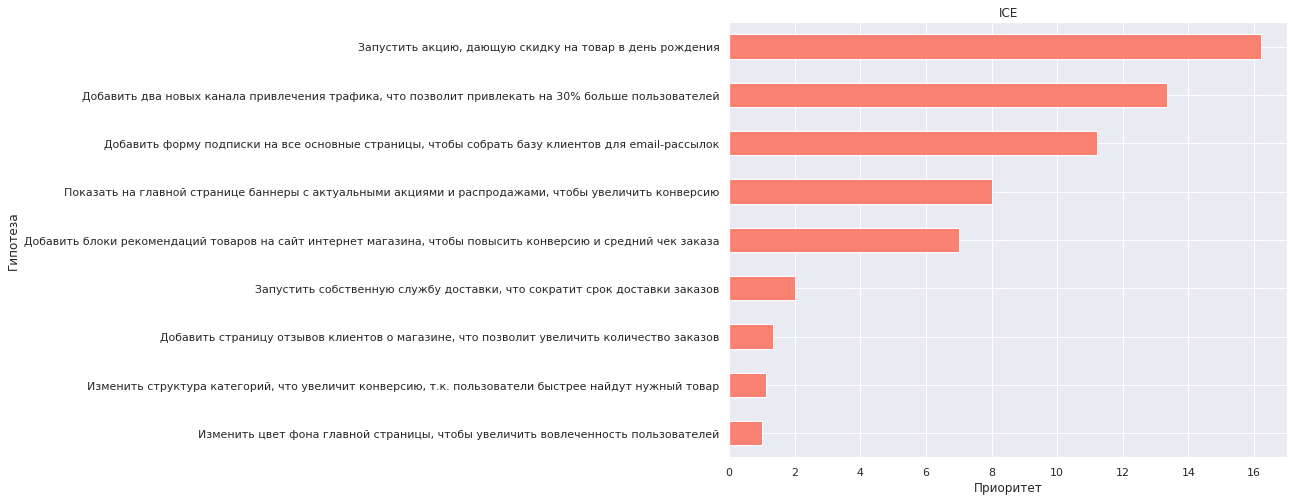

In [22]:
ax = hypothesis[['hypothesis', 'ICE']].set_index('hypothesis').sort_values('ICE', ascending=True).plot(kind='barh', color='salmon')
ax.set_xlabel('Приоритет')
ax.set_ylabel('Гипотеза')
ax.set_title('ICE')
ax.get_legend().remove()
plt.show()

# Промежуточный вывод
Топ-3 гипотез по фреймворк ICE: 8, 0 и 7 гипотеза.

### Применим фреймворк RICE для приоритизации гипотез. 
Отсортируем по убыванию приоритета.

In [23]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

In [24]:
hypothesis.sort_values('RICE', ascending=False).head(10)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.20,112.00
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.00,56.00
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.33,40.00
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.00,40.00
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.20,16.20
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.12,9.00
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.33,4.00
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.00,3.00


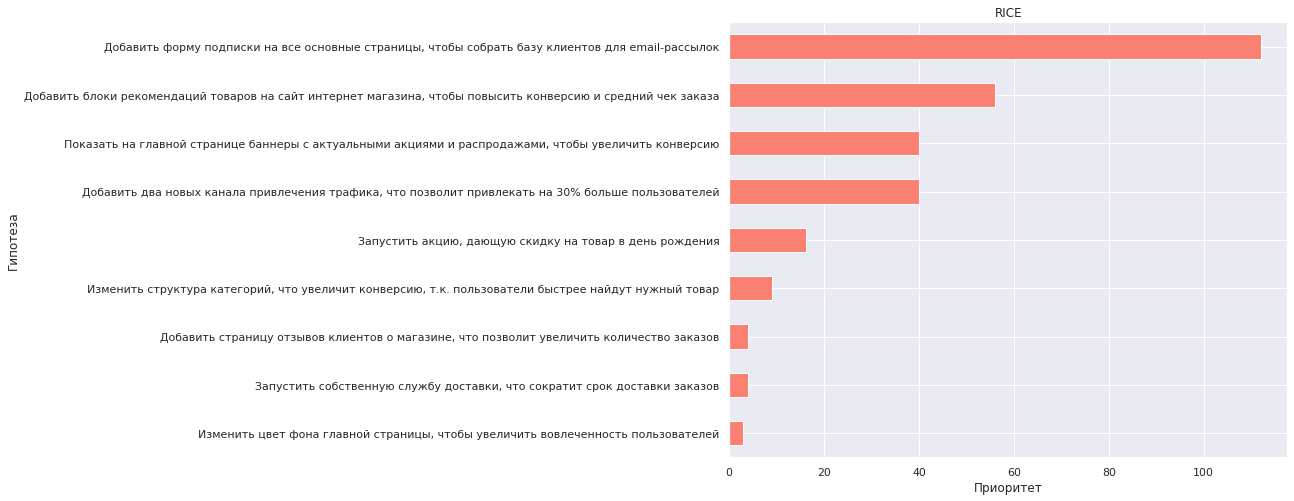

In [25]:
ax = hypothesis[['hypothesis', 'RICE']].set_index('hypothesis').sort_values('RICE', ascending=True).plot(kind='barh', color='salmon')
ax.set_xlabel('Приоритет')
ax.set_ylabel('Гипотеза')
ax.set_title('RICE')
ax.get_legend().remove()
plt.show()

# Промежуточный вывод
Топ-3 гипотез по фреймворк RICE : 7, 2 и 0 гипотеза.

Можно отметить, что гипотеза 8 - опустилась на несколько позиций вниз. Это объясняется тем, что охват по 8 гипотезе составляет. В то время как 7 гипотеза, в силу большого охвата, вырвалась в лидеры.
Не удивительно, что 8 так сильно опустилась. Ведь её охват всего 1, в то время как 7, в силу большого охвата (равен 10) вырвалась в лидеры.

Параметр охвата (reach), использующийся в методе RICE изменил всю приоритетность, полученную по методу ICE:

- без учета охвата на 1ом месте идет акция со скидкой имениннику, но параметр reach справедливо понизил приоритет этой акции, так как  охват её минимальный (по сравнению с другими гипотезами увеличения выручки);
- тоже произошло и с гипотезой о добавлении 2х каналов трафика, с организацией своей службы доставки и с идеей о добавлении страницы отзывов;
- без изменений осталась рейтинговая позиция гипотез о добавлении баннеров с актуальными акциями на главную страницу и идея с изменением цвета фона главной страницы);
- выросли в рейтинге (стали более приоритетными) RICE (по сравнению с ICE) гипотеза о добавлении формы подписки на все основные страницы ресурса, о добавлении блоков рекомендаций товаров и предложение об изменении структуры категорий.


## Анализ A/B-теста.
Предварительно изучим количество заказов и посещений в каждой из групп.

In [26]:
print ('Количество посещений в группе А -', visitors.query('group == "A"')['visitors'].sum())
print ('Количество посещений в группе B -',visitors.query('group == "B"')['visitors'].sum())
print('-----------------------------------')
print ('Количество заказов в группе А -', orders.query('group == "A"').shape[0])
print ('Количество заказов в группе B -',orders.query('group == "B"').shape[0])

Количество посещений в группе А - 18736
Количество посещений в группе B - 18916
-----------------------------------
Количество заказов в группе А - 557
Количество заказов в группе B - 640


В группе "В" на 180 посещений больше, чем в группе "А". 

Проверим, не попали ли некоторые пользователи в разные группы.

In [27]:
visitorsA = orders[orders['group']=='A']['visitorid']
visitorsB = orders[orders['group']=='B']['visitorid']

In [28]:
visitors_AB = orders.loc[orders['visitorid'].isin(visitorsA)& orders['visitorid'].isin(visitorsB),'visitorid'].unique()

Вычистим таких пользователей из заказов. Было:

In [29]:
(orders.groupby('visitorid')['group'].nunique()>1).count()

1031

Стало:

In [30]:
orders = orders.loc[~orders['visitorid'].isin(visitors_AB)]
(orders.groupby('visitorid')['group'].nunique()>1).count()

973

In [31]:
print ('Количество заказов в группе А -', orders.query('group == "A"').shape[0])
print ('Количество заказов в группе B -',orders.query('group == "B"').shape[0])

Количество заказов в группе А - 468
Количество заказов в группе B - 548


Теперь разница по количеству заказов между группами уменьшилась до 80. Однако в процентом соотношение разница увеличилась. 
Оставим пока, как есть. Учтем на будущее.

In [32]:
orders_grouped = (orders.groupby(['date','group'], as_index=False)
                        .agg({'transactionid':'nunique','visitorid':'nunique','revenue':'sum'}))\
                        .rename(columns={'transactionid':'orders','visitorid':'buyers'})
orders_grouped['group_copy'] = orders_grouped['group']
orders_grouped = orders_grouped.set_index(['date','group'])
orders_cumsum = orders_grouped.sort_values(['date','group']).groupby('group_copy').cumsum().reset_index()

Посчитаем сумму визитов по дням в каждой группе.

In [33]:
visitors_cumsum = visitors.groupby(['date','group'], as_index=False).agg({'visitors':'sum'}).sort_values(['date','group'])

Скопируем group чтобы провести по ней кумулятивную сумму.

In [34]:
visitors_cumsum['group_copy'] = visitors_cumsum['group']
visitors_cumsum = visitors_cumsum.set_index(['date','group']).groupby('group_copy').cumsum().reset_index()

In [35]:
cummulative = orders_cumsum.join(visitors_cumsum[['visitors']])

In [36]:
cummulative['average_check'] = cummulative['revenue'] / cummulative['orders']
cummulative['conversion'] = cummulative['orders'] / cummulative['visitors']

In [37]:
cummulative.head(10)

,date,group,orders,buyers,revenue,visitors,average_check,conversion
0,2019-08-01,A,23,19,142779,719,"6,207.78",0.03
1,2019-08-01,B,17,17,59758,713,"3,515.18",0.02
2,2019-08-02,A,42,37,234381,1338,"5,580.50",0.03
3,2019-08-02,B,40,39,221801,1294,"5,545.02",0.03
4,2019-08-03,A,66,61,346854,1845,"5,255.36",0.04
5,2019-08-03,B,54,53,288850,1803,"5,349.07",0.03
6,2019-08-04,A,77,72,388030,2562,"5,039.35",0.03
7,2019-08-04,B,68,66,385740,2573,"5,672.65",0.03
8,2019-08-05,A,99,94,474413,3318,"4,792.05",0.03
9,2019-08-05,B,89,87,475648,3280,"5,344.36",0.03


### Построим график кумулятивной выручки по группам, предварительно изучив количество заказов в каждой из групп.

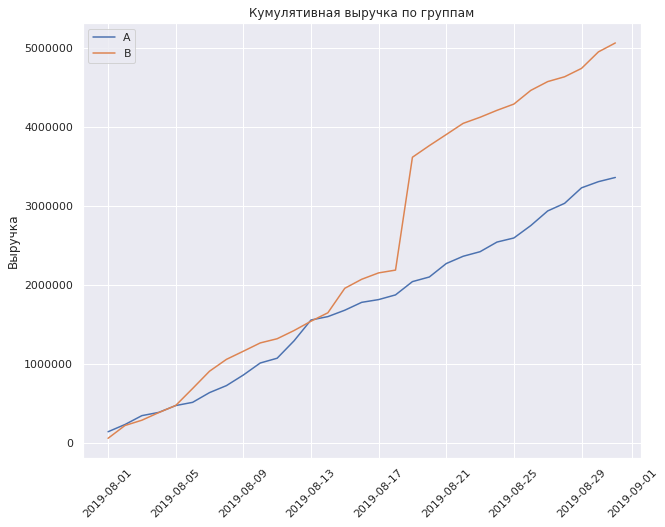

In [38]:
cummulativeA = cummulative[cummulative['group']=='A'][['date', 'revenue']]
cummulativeB = cummulative[cummulative['group']=='B'][['date', 'revenue']]
plt.plot(cummulativeA.iloc[:,0].to_frame(), cummulativeA.iloc[:,1].to_frame(), label='A' )
plt.plot(cummulativeB.iloc[:,0].to_frame(), cummulativeB.iloc[:,1].to_frame(), label='B')
plt.title('Кумулятивная выручка по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Промежуточный вывод

Группа "А" растет постепенно, в то время как группа "В" имеет резкий рост после 2019-08-17.

Вероятно, там закрались очень большие покупки. Хорошо, что в группе "В" больше заказов. При отсеивании аномалий мы выровняли количество участников теста.

### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

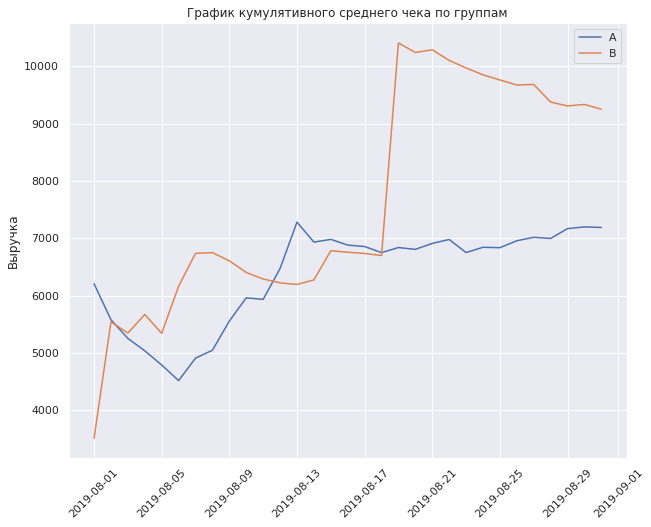

In [39]:
cummulativeA = cummulative[cummulative['group']=='A'][['date', 'average_check']]
cummulativeB = cummulative[cummulative['group']=='B'][['date', 'average_check']]
plt.plot(cummulativeA.iloc[:,0].to_frame(), cummulativeA.iloc[:,1].to_frame(), label='A' )
plt.plot(cummulativeB.iloc[:,0].to_frame(), cummulativeB.iloc[:,1].to_frame(), label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Промежуточный вывод

Средний чек обеих групп выравнивается после 2019-08-13. Однако, в очередной раз видим, что по группе В есть крупная покупка после 2019-08-17 и после данной покупки чек этой группы начинает снижаться.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

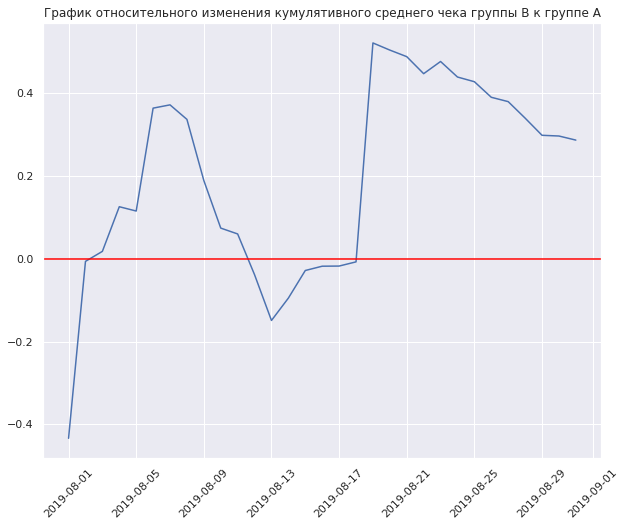

In [40]:
temp = (cummulativeA[['date', 'average_check']].merge(cummulativeB[['date', 'average_check']], 
                                            left_on='date', right_on='date', how='left', suffixes=['_A', '_B']))
plt.plot(temp['date'], temp['average_check_B'] / temp['average_check_A']-1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.axhline(y=0, color='red', linestyle='-')
plt.xticks(rotation=45)
plt.show()

# Промежуточный вывод

Очередное подтверждение того, что где-то прячутся крупные заказы. Ранее складывалось впечатление, что крупные заказы имеются где-то после 2019-08-17. Однако следует отметить, что они могут быть и в начале.

### Построим график кумулятивной конверсии по группам.

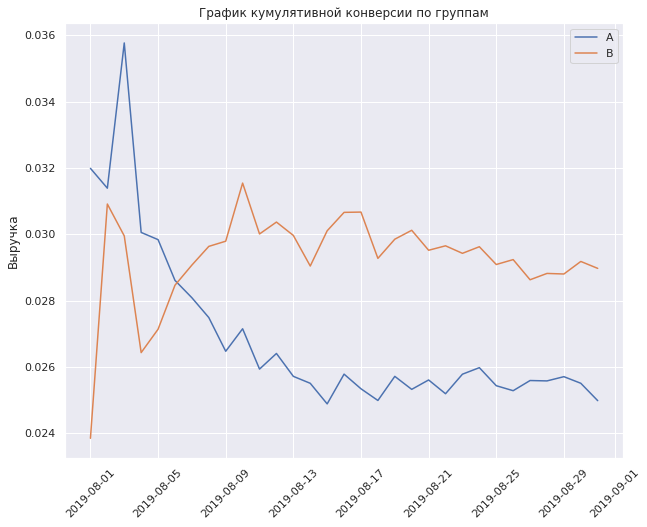

In [41]:
cummulativeA = cummulative[cummulative['group']=='A'][['date', 'conversion']]
cummulativeB = cummulative[cummulative['group']=='B'][['date', 'conversion']]
plt.plot(cummulativeA.iloc[:,0].to_frame(), cummulativeA.iloc[:,1].to_frame(), label='A' )
plt.plot(cummulativeB.iloc[:,0].to_frame(), cummulativeB.iloc[:,1].to_frame(), label='B')
plt.title('График кумулятивной конверсии по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Промежуточный вывод


Получился интересный результат, на первых этапах конверсия в обеих группах "прыгала", но потом выровнялась, и по графику видно, что группа В лидирет.

После Пика у обоих групп, А-конверсия варьируется в районе от 0,029 и до 0,031. В-конверсия от 0,037 и до 0,033. 

Разница между группами порядка 0.2% в абсолютном значение

### Построим график относительного изменения кумулятивной конверсии группы B к группе A.

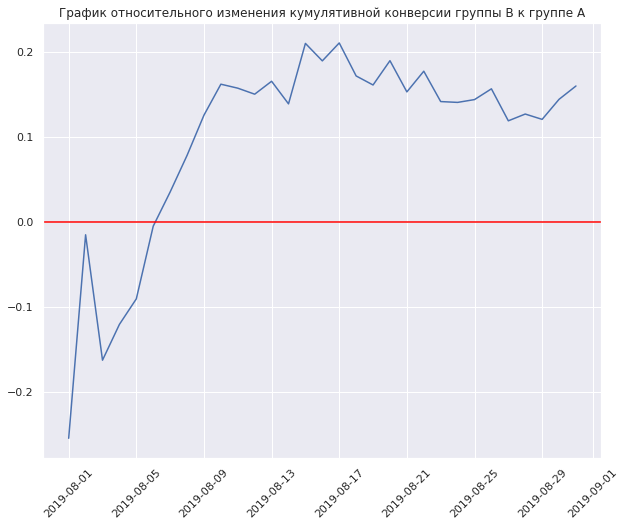

In [42]:
temp = (cummulativeA[['date', 'conversion']].merge(cummulativeB[['date', 'conversion']], 
                                            left_on='date', right_on='date', how='left', suffixes=['_A', '_B']))
plt.plot(temp['date'], temp['conversion_B'] / temp['conversion_A']-1)
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.axhline(y=0, color='red', linestyle='-')
plt.xticks(rotation=45)
plt.show()

# Промежуточный вывод

Группа B брала разгон в начале теста, и теперь стабильно и существенно обгоняет группу А. Однако количество дней теста небольшое.


### Построим точечный график количества заказов по пользователям.

Изучим аномалии, как было ранее отмечено. Скорее всего имеются аномально дорогие заказы. Для начала рассмотрим стоимость заказов.

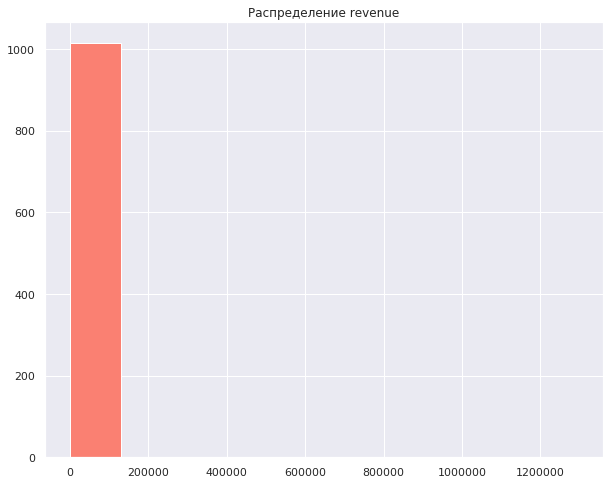

In [43]:
plt.hist(orders['revenue'], color='salmon')
plt.title('Распределение revenue');

Мы видим, что имеются какие-то очень большие заказы.

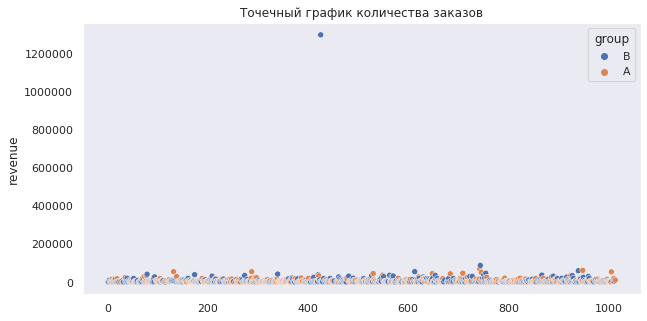

In [44]:
x_values = pd.Series(range(0,orders['revenue'].count())) # сериес для 

plt.figure(figsize=(10, 5))
sns.scatterplot(x=x_values, y="revenue", hue="group",
                     data=orders)
plt.grid()
plt.title('Точечный график количества заказов');

Как было ранее отмечено, средний чек и выручка по группе "В" довольно сильно увеличивается за счет всего одного заказа. 

Рассмотрим более детально.

[26785. 53904.]


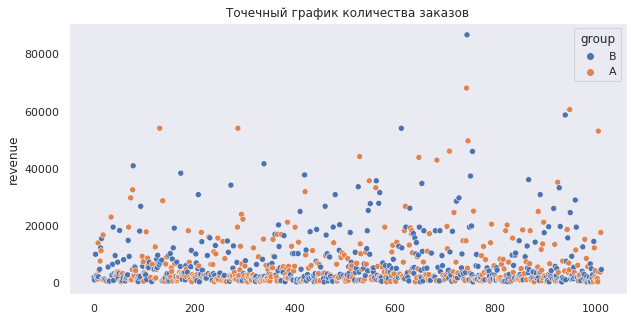

In [45]:
orders_clean = orders.query('revenue<200000')
x_values = pd.Series(range(0,orders_clean['revenue'].count())) # сериес для оси Х
plt.figure(figsize=(10, 5))
sns.scatterplot(x=x_values, y="revenue", hue="group",
                     data=orders_clean)
plt.grid()
plt.title('Точечный график количества заказов');
print(np.percentile(orders['revenue'], [95, 99]))

Все не так плохо. В связи с чем, принимаю решение убрать данные, которые выше 99 перцентиля.

In [46]:
per_99 = np.percentile(orders['revenue'], [99])[0]
orders_clean = orders.query('revenue<= @per_99')

Таблица с заказами очищена от аномально дорогих заказов. 

Приступим к изучению количества заказов.

In [47]:
orders_by_users = (orders.groupby('visitorid')['revenue'].count()
                   .reset_index()
                   .rename(columns={'revenue':'orders'}))

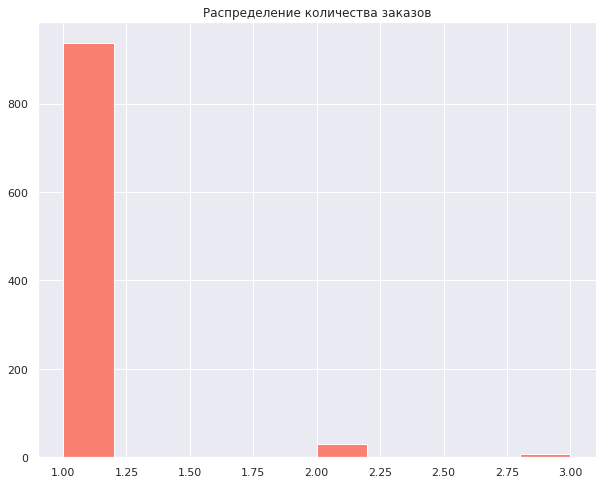

In [48]:
orders_by_users['orders'].hist(color='salmon')
plt.title('Распределение количества заказов');

Мы можем видеть, что клиенты делают 1 заказ, намного реже 2 заказа и совсем редко 3 заказа.

[1. 2.]


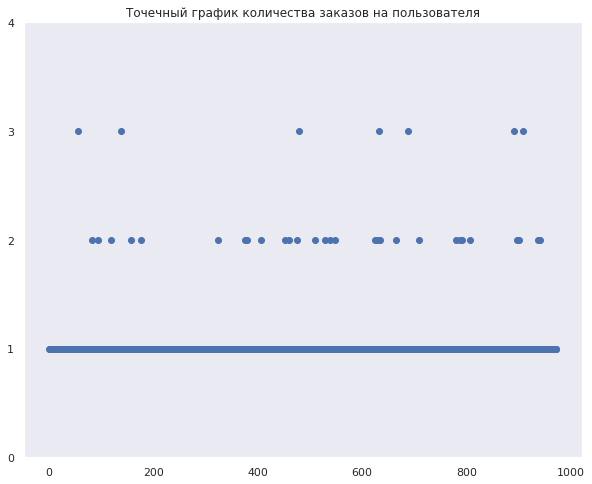

In [49]:
x_values = pd.Series(range(0,orders_by_users['orders'].count())) # сериес для оси х
plt.scatter(data=orders_by_users, x=x_values, y='orders') 
plt.grid()
plt.title('Точечный график количества заказов на пользователя')
plt.yticks([0,1,2,3,4]);
print(np.percentile(orders_by_users['orders'], [95, 99]))

Основываясь на графике принимаем решение, что больше 2 заказов это уже перебор. 

Уберем таких пользователей.

In [50]:
per_99 = np.percentile(orders_by_users['orders'], [99])[0]
orders_by_users_clean = orders_by_users.query('orders<= @per_99')

Сформируем итоговую таблицу заказов без аномалий.

In [51]:
orders_clean = orders_clean.loc[orders_clean['visitorid'].isin(orders_by_users_clean['visitorid'])]

# Промежуточный вывод

Таким образом, были изучены "сырые" данные. Была подготовлена таблица с данными о заказов без аномалий. С учетом аномалий группа "В" казалась предпочтительнее. Однако у неё были найдены серьезные аномалии. От которых мы благополучно избавились. Перейдем к заключительной части, постараемся узнать какая из групп предпочтительнее.


## Статистическая значимость.
### "Сырые" данные.

Для проверки будем использовать непараметрический критерий Манна-Уитни, так как с большой долей вероятности можно утверждать, что данные у нас распределены ненормально.

Создадим таблицу с данными по заказам на каждого пользователя.

In [52]:
orders_by_usersA = orders[orders['group']=='A'].groupby('visitorid')['transactionid'].nunique().reset_index()
orders_by_usersA.columns=['visitorsid','orders']

orders_by_usersB = orders[orders['group']=='B'].groupby('visitorid')['transactionid'].nunique().reset_index()
orders_by_usersB.columns=['visitorsid','orders']

Сформируем таблицы с пользователями без заказов:

1. Вычтем из общего числа визитов число заказов, получаем количество пользователей, которые не совершили заказ.
2. Формируем Series, в котором все значения будут равны 0, а количество таких значений - это результат операции описанной выше.
3. Объедим с пользователями, которые делали заказы.

In [53]:
freeloadersA = pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visitors'].sum() - len(orders_by_usersA['orders'])), name='orders')
freeloadersB = pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visitors'].sum() - len(orders_by_usersB['orders'])), name='orders')

Создадим выборки с сырыми данными для статистических тестов.

In [54]:
sampleA = pd.concat([orders_by_usersA['orders'], freeloadersA])
sampleB = pd.concat([orders_by_usersB['orders'], freeloadersB])

Применим озвученный ранее критерий к сырым данным и посмотрим на значение средний конверсий.

- H0 - конверсия группы "А" = конверсии группы "В".
- H1 - конверсии групп не равны.

Примем для себя уровень значимости alpha = 0.05

In [55]:
print('p_value: {:.5f}'.format(st.mannwhitneyu(sampleA, sampleB)[1]))
print('Средняя конверсия группы А: {:.1%}'.format(sampleA.mean()))
print('Средняя конверсия группы B: {:.1%}'.format(sampleB.mean()))

p_value: 0.00551
Средняя конверсия группы А: 2.5%
Средняя конверсия группы B: 2.9%


Так как p_value меньше заданного значения alpha, то мы отвергаем гипотизу о равенстве средний конверсий. В абсолютных значениях эта разница составила 0.4%, или на 16%, что в нашем случае оказалось статистически значимым.

Далее изучим различие среднего чека по сырым данным.

- H0 - средний чек группы "А" = чеку группы "В".
- H1 - средний чек групп не равен.

Примем для себя уровень значимости alpha = 0.05

In [56]:
print('p_value: {:.5f}'.format(
    st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
))
print('Средний чек группы А: {:.2f}'.format(orders[orders['group']=='A']['revenue'].mean()))
print('Средний чек группы B: {:.2f}'.format(orders[orders['group']=='B']['revenue'].mean()))

p_value: 0.41475
Средний чек группы А: 7189.44
Средний чек группы B: 9249.95


Несмотря на разницу среднего чека в 2000 у.е., тест показывает, что мы не можем отвергнуть нулевую гипотизу о равенстве средних. То есть, такое различие не статистически значимо.

Это были "сырые" данные, теперь рассмотрим очищенные.

### Очищенные данные.

Ранее уже была подготовлена таблица с "чистыми" заказами, воспользуемся ей и кодом для "сырых" данных.

In [57]:
orders_by_usersA = orders_clean[orders_clean['group']=='A'].groupby('visitorid')['transactionid'].nunique().reset_index()
orders_by_usersA.columns=['visitorsid','orders']

orders_by_usersB = orders_clean[orders_clean['group']=='B'].groupby('visitorid')['transactionid'].nunique().reset_index()
orders_by_usersB.columns=['visitorsid','orders']

In [58]:
freeloadersA = pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visitors'].sum() - len(orders_by_usersA['orders'])), name='orders')
freeloadersB = pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visitors'].sum() - len(orders_by_usersB['orders'])), name='orders')

Создадим выборки с "чистыми" данными для статистических тестов.

In [59]:
sampleA = pd.concat([orders_by_usersA['orders'], freeloadersA])
sampleB = pd.concat([orders_by_usersB['orders'], freeloadersB])

In [60]:
print('p_value: {:.5f}'.format(st.mannwhitneyu(sampleA, sampleB)[1]))
print('Средняя конверсия (очищенная) группы А: {:.1%}'.format(sampleA.mean()))
print('Средняя конверсия (очищенная) группы B: {:.1%}'.format(sampleB.mean()))

p_value: 0.00348
Средняя конверсия (очищенная) группы А: 2.4%
Средняя конверсия (очищенная) группы B: 2.8%


На "очищенных" данных ситуация с конверсией почти не изменилась, только конверсия немного уменьшилась. Группа "В", по прежнему, в лидерах по конверсии. 

Отвергаем H0 о равенстве конверсий.

In [61]:
print('p_value: {:.5f}'.format(
    st.mannwhitneyu(orders_clean[orders_clean['group']=='A']['revenue'], orders_clean[orders_clean['group']=='B']['revenue'])[1]
))
print('Средний чек (очищенный) группы А: {:.2f}'.format(orders_clean[orders_clean['group']=='A']['revenue'].mean()))
print('Средний чек (очищенный) группы B: {:.2f}'.format(orders_clean[orders_clean['group']=='B']['revenue'].mean()))

p_value: 0.39385
Средний чек (очищенный) группы А: 6487.02
Средний чек (очищенный) группы B: 6277.27


Такая же ситуация с тестом и по среднему чеку, мы по прежнему не можем отвергнуть нулевую гипотезу о равенстве среднего чека. Однако, средние чеки значительно выровнялись, более нет такой большой разницы между группами "А" и "В" по среднему чеку.

Подготовим данные для визуализации куммулитивной выручки по очищенным данным.

In [62]:
dates_groups = orders[['date','group']].drop_duplicates()

In [63]:
orders_aggregated = (dates_groups
                     .apply(lambda x: orders_clean[np.logical_and(orders_clean['date'] <= x['date']
                                                            , orders_clean['group'] ==  x['group'])]
                    .agg({'date':'max', 'group':'max', 'revenue':'sum', 'transactionid':'nunique'}), axis=1) 
                    .sort_values(by=['date','group']))
                    
orders_aggregated.rename(columns={'transactionid':'orders_clean'}, inplace=True)

visitors_aggregated = (dates_groups
                     .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date']
                                                            , visitors['group'] ==  x['group'])]
                    .agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis=1) 
                    .sort_values(by=['date','group']))
visitors_aggregated.head()

cumulative_data = orders_aggregated.merge(visitors_aggregated, on=['date','group'])
cumulative_data.head()



from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# Построим график кумулятивной выручки по группам, предварительно изучив количество заказов в каждой из групп
cumulative_a = cumulative_data.loc[cumulative_data['group'] == 'A',['date','revenue','orders_clean','visitors']]
cumulative_b = cumulative_data.loc[cumulative_data['group'] == 'B',['date','revenue','orders_clean','visitors']]

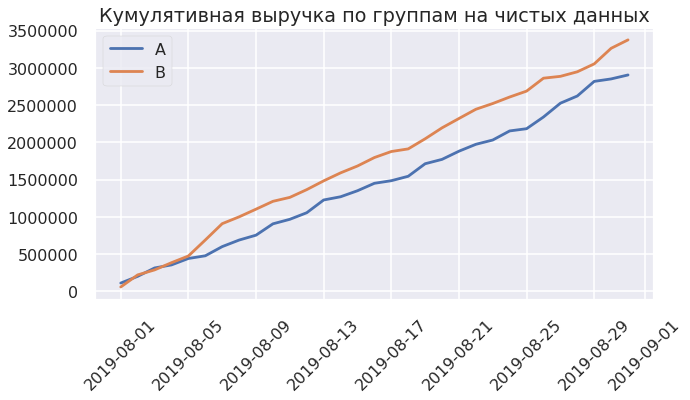

In [64]:
plt.style.use('seaborn-poster')
plt.figure(figsize=(10, 5))
plt.plot(cumulative_a['date'], cumulative_a['revenue'], label='A')
plt.plot(cumulative_b['date'], cumulative_b['revenue'], label='B')
plt.xticks(rotation=45)
plt.title('Кумулятивная выручка по группам на чистых данных')
plt.legend(loc='best');

# Общий вывод

В результате проведеной проектной работы мной были рассмотрены данные нескольких файлов и совершена предобработка. Данные были проверены на наличие пропущенных значений, некорретные типы данных. Все данные представлены в удобном формате. На основании всего вышесказанного мы можем констатировать следующее:

- На "чистых" данных, была выявлена статистическая значимость в конверсиях двух групп. Конверсия в группе "В" выше. На графике (выше), мы видим, что конверсия группы "В" зафиксировалась примерно на одном уровне.
- В среднем чеке групп не было найден статистически значимых различий. В то время как у группы "В" он немного меньше.
- Учитывая, что конверсия группы "В" больше, чем у группы "А" и больший размер куммулитивной выручки, следует принять решение - тест можно остановить и считать успешно проведенным. Зафиксировать победу группы "В".

Результаты A/B-теста:

- по конверсии между группами A и B (как по сырым данным, так и по очищенным) есть статистически значимые различия;
- по среднему чеку между группами A и B (как по сырым данным, так и по очищенным) нет статистически значимых различий.


Помимо этого, в процессе работы с данными было выяснено, что некоторые пользователи от сессии к сессии могли видеть как одну версию сайта, так и другую, что нарушает один из основных принцип работы A/B-теста - один пользователь видит только одну версию на всём протяжении теста.
В связи с этим, нам необходимо проверить корректность отработки метода показа пользователям одной или другой версии сайта и поправить его, чтобы одному и тому же пользователю показывалась только та версия сайта, которую он увидел при первом визите.